In [84]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# imports
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import _pickle as pickle
import random
import os
import time
import math
import matplotlib.pyplot as plt 

## Download and Unzip the Data

In [7]:
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip -P ~/data/wikitext/

--2018-05-16 22:53:46--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.100.181
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.100.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4475746 (4.3M) [application/zip]
Saving to: ‘/home/paperspace/data/wikitext/wikitext-2-v1.zip’

wikitext-2-v1.zip   100%[===================>]   4.27M  2.19MB/s    in 1.9s    

2018-05-16 22:53:48 (2.19 MB/s) - ‘/home/paperspace/data/wikitext/wikitext-2-v1.zip’ saved [4475746/4475746]



In [11]:
!unzip /home/paperspace/data/wikitext/wikitext-2-v1.zip -d /home/paperspace/data/wikitext/

Archive:  /home/paperspace/data/wikitext/wikitext-2-v1.zip
   creating: /home/paperspace/data/wikitext/wikitext-2/
  inflating: /home/paperspace/data/wikitext/wikitext-2/wiki.test.tokens  
  inflating: /home/paperspace/data/wikitext/wikitext-2/wiki.valid.tokens  
  inflating: /home/paperspace/data/wikitext/wikitext-2/wiki.train.tokens  


## Take a peek at the files

In [16]:
! cat /home/paperspace/data/wikitext/wikitext-2/wiki.valid.tokens | head -10

 
 = Homarus gammarus = 
 
 Homarus gammarus , known as the European lobster or common lobster , is a species of <unk> lobster from the eastern Atlantic Ocean , Mediterranean Sea and parts of the Black Sea . It is closely related to the American lobster , H. americanus . It may grow to a length of 60 cm ( 24 in ) and a mass of 6 kilograms ( 13 lb ) , and bears a conspicuous pair of claws . In life , the lobsters are blue , only becoming " lobster red " on cooking . Mating occurs in the summer , producing eggs which are carried by the females for up to a year before hatching into <unk> larvae . Homarus gammarus is a highly esteemed food , and is widely caught using lobster pots , mostly around the British Isles . 
 
 = = Description = = 
 
 Homarus gammarus is a large <unk> , with a body length up to 60 centimetres ( 24 in ) and weighing up to 5 – 6 kilograms ( 11 – 13 lb ) , although the lobsters caught in lobster pots are usually 23 – 38 cm ( 9 – 15 in ) long and weigh 0 @.@ 7 – 2 @.@

In [13]:
PATH=Path("/home/paperspace/data/wikitext/wikitext-2")
list(PATH.iterdir())

[PosixPath('/home/paperspace/data/wikitext/wikitext-2/wiki.train.tokens'),
 PosixPath('/home/paperspace/data/wikitext/wikitext-2/wiki.valid.tokens'),
 PosixPath('/home/paperspace/data/wikitext/wikitext-2/wiki.test.tokens')]

## Set up some helper objects

In [88]:
# ========================================================================
# Helper Objects
# ========================================================================

class Dictionary(object):
    def __init__(self):
        """ Initializes both conversions of the dictionary """
        self.word2idx = {"UNK": 0}
        self.idx2word = ["UNK"]

    def add_word(self, word):
        """ Adds a new word to the dictionary. gives it an auto incremented ID"""
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        """ Returns the number of tokens in the word"""
        return len(self.idx2word)
    
    def to_pkl(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump([self.word2idx, self.idx2word],f)
        


class Corpus(object):
    def __init__(self, path, ):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'wiki.train.tokens'), add=True)
        self.valid = self.tokenize(os.path.join(path, 'wiki.valid.tokens'))
        self.test = self.tokenize(os.path.join(path, 'wiki.test.tokens'))
        
    def count_words(self, path, add=False):
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                tokens += len(words)
                if add:
                    for word in words:
                        self.dictionary.add_word(word)
        return tokens

    def tokenize(self, path, add=False):
        """Tokenizes a text file."""
        tokens = self.count_words(path, add)
        # Tokenize file content
        with open(path, 'r') as f:
            ids = torch.LongTensor(tokens)
            token = 0
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    ids[token] = self.dictionary.word2idx.get(word, 0)
                    token += 1
        return ids

# ========================================================================
# Helper functions
# ========================================================================

def batchify(data, bsz):
    """
    Takes any dataset and returns a sub-batched version
    [1,2,3,4,5,6,7,8,9,10], batchsize = 3 will give
    (1,2,3) (4,5,6) (7,8,9)
    """
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.cuda()

def get_batch(source, i, bptt, evaluation=False):
    """
    Source: data array
    i: index
    bptt: back prop through time
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = Variable(source[i:i+seq_len], volatile=evaluation)
    target = Variable(source[i+1:i+1+seq_len].view(-1))
    return data, target

def save_model(m, p): torch.save(m.state_dict(), p)

def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_data, criterion, lr_low=1e-3, lr_high=10, epochs=2):
    losses = []
    (train_data.size(0) - 1)//bptt + 1
    iterations = epochs * ((train_data.size(0) - 1)//bptt + 1)
    delta = (lr_high - lr_low)/(iterations-1)
    losses = []
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    total_loss = 0
    ntokens = len(corpus.dictionary)
    for i in range(epochs):
        hidden = model.init_hidden(batch_size)
        for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
            lr = lrs[ind]
            data, targets = get_batch(train_data, i, bptt)
        
            hidden = Variable(hidden.data) #.detach()
            model.zero_grad()
            output, hidden = model(data, hidden)
            loss = criterion(output.view(-1, ntokens), targets)
            loss.backward()

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)
            for p in model.parameters():
                p.data.add_(-lr, p.grad.data)

            losses.append(loss.data[0])
            ind += 1
    return lrs, losses 

def get_triangular_lr2(lr_low, lr_high, iterations):
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3


def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(batch_size)
    for i in range(0, data_source.size(0) - 1, bptt):
        data, targets = get_batch(data_source, i, bptt, evaluation=True)
        output, hidden = model(data, hidden)
        output_flat = output.view(-1, ntokens)
        total_loss += len(data) * criterion(output_flat, targets).data
        hidden = Variable(hidden.data) #.detach()
    return total_loss[0] / len(data_source)


# ========================================================================
# Model functions
# ========================================================================

class RNNModel(nn.Module):
    """
    Container module with an encoder, a recurrent module, and a decoder.
    
    ntoken: number of tokens
    ninp: number of inputs
    nhid: number of hidden units
    nlayers: number of layers
    dropout: % dropout
    """

    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.5):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.GRU(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)
        self.init_weights()
        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        init_range = 0.1
        self.encoder.weight.data.uniform_(-init_range, init_range)
        self.decoder.bias.data.fill_(0.0)
        self.decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self, input, hidden):
        """
        input: current input
        hidden: hidden state from the previous step
        """
        # pulls the embeddings for the input submitted
        emb = self.drop(self.encoder(input))
        
        # then applies the RNN against the embedding layer
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, bsz):
        """
        Initialize the hidden weights
        """
        weight = next(self.parameters()).data
        return Variable(weight.new(self.nlayers, bsz, self.nhid).zero_())
    


def train_triangular_policy(model, epochs=4, lr_low=1e-4, lr_high=4):
    # Turn on training mode which enables dropout.
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    iterations = epochs * ((train_data.size(0) - 1)//bptt + 1)
    lrs = get_triangular_lr2(lr_low, lr_high, iterations)
    idx = 0
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        start_time = time.time()
        
        # initialize the model
        # these are the weights from hidden layers
        hidden = model.init_hidden(batch_size)
        
        for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
            lr = lrs[idx]
            
            # get a single batch of data (iterator)
            data, targets = get_batch(train_data, i, bptt)
            
            # Starting each batch, we detach the hidden state from how it was previously produced.
            # If we didn't, the model would try backpropagating all the way to start of the dataset.
            hidden = Variable(hidden.data) #.detach()
            model.zero_grad()
            
            # run the data through the model
            # this would be a small snippet of the phrase
            output, hidden = model(data, hidden)
            loss = criterion(output.view(-1, ntokens), targets)
            loss.backward()

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)
            for p in model.parameters():
                p.data.add_(-lr, p.grad.data)

            total_loss += len(data)*loss.data
            idx += 1
        # results after each epoch
        val_loss = evaluate(val_data)
        elapsed = time.time() - start_time
        train_loss = total_loss[0]/len(train_data)
        print('| epoch {:3d} | lr {:02.5f} | t_loss {:5.2f} | t_ppl {:5.2f} | v_loss {:5.2f} | v_ppl {:5.2f}'.format(
             epoch, lr, train_loss, math.exp(train_loss), val_loss, math.exp(val_loss)))

In [89]:
corpus = Corpus(PATH)
len(corpus.dictionary)

33279

In [73]:
# Sample tokenization using a corpus
with open(PATH/'sample.txt','w') as f:
    f.write('man met a dog')
corpus.tokenize(PATH/'sample.txt')


 2319
  137
   28
 5648
    1
[torch.LongTensor of size 5]

In [50]:
batch_size = 20
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, batch_size)
test_data = batchify(corpus.test, batch_size)

In [51]:
nemb = 300
nhid = 300
bptt = 35
clip = 0.25
nlayers = 2
ntokens = len(corpus.dictionary)
criterion = nn.CrossEntropyLoss()
model = RNNModel(ntokens, nemb, nhid, nlayers).cuda()
lrs, losses = LR_range_finder(model, train_data, criterion)

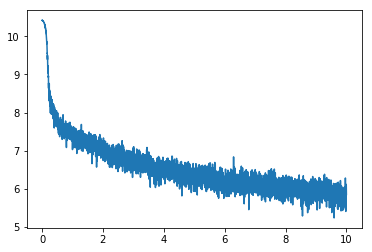

In [53]:
plt.plot(lrs, losses)
plt.show()

In [54]:
steps = 10
nemb = 300
nhid = 300
nlayers = 2
ntokens = len(corpus.dictionary)
model = RNNModel(ntokens, nemb, nhid, nlayers).cuda()

In [62]:
runs = [
    [4,10],
    [4,10],
    [2,8],
    [2,8],
    [1,6],
    [1,6],
    [0.5,4],
    [0.5,4],
    [0.1,2],
    [0.1,2]    
]
for run in runs:
    train_triangular_policy(model, epochs=4, lr_low=run[0], lr_high=run[1])

| epoch   0 | lr 8.28489 | t_loss  5.90 | t_ppl 364.66 | v_loss  5.68 | v_ppl 292.48
| epoch   1 | lr 7.42878 | t_loss  5.65 | t_ppl 283.10 | v_loss  5.43 | v_ppl 227.92
| epoch   2 | lr 4.63954 | t_loss  5.37 | t_ppl 214.31 | v_loss  5.23 | v_ppl 185.87
| epoch   3 | lr 4.00000 | t_loss  5.22 | t_ppl 185.14 | v_loss  5.16 | v_ppl 173.31
| epoch   0 | lr 8.28489 | t_loss  5.17 | t_ppl 175.33 | v_loss  5.21 | v_ppl 183.51
| epoch   1 | lr 7.42878 | t_loss  5.17 | t_ppl 175.81 | v_loss  5.13 | v_ppl 169.35
| epoch   2 | lr 4.63954 | t_loss  5.01 | t_ppl 150.21 | v_loss  5.04 | v_ppl 154.18
| epoch   3 | lr 4.00000 | t_loss  4.91 | t_ppl 136.23 | v_loss  5.00 | v_ppl 147.98
| epoch   0 | lr 6.28489 | t_loss  4.86 | t_ppl 128.80 | v_loss  5.04 | v_ppl 153.78
| epoch   1 | lr 5.42878 | t_loss  4.90 | t_ppl 133.96 | v_loss  5.02 | v_ppl 151.62
| epoch   2 | lr 2.63954 | t_loss  4.79 | t_ppl 120.11 | v_loss  4.93 | v_ppl 138.39
| epoch   3 | lr 2.00000 | t_loss  4.72 | t_ppl 112.24 | v_loss  

In [63]:
p = PATH/"mode117.pth"
save_model(model, str(p))

In [65]:
os.listdir(PATH)

['wiki.train.tokens', 'mode117.pth', 'wiki.valid.tokens', 'wiki.test.tokens']

In [90]:
corpus.dictionary.to_pkl('dict17.pkl')

In [94]:
emb = model.encoder

array([[-5.3439606e-02,  2.0715311e-02,  9.1994025e-02, ...,
        -6.1570562e-02,  5.3499438e-02, -4.3861378e-02],
       [ 1.0782615e-02,  1.7795961e-01,  9.4854139e-04, ...,
         1.5818091e-01, -7.0780493e-02,  7.3512267e-05],
       [-4.4077042e-02,  1.1453146e-01,  1.2156373e-02, ...,
         1.2476309e-01, -2.0462185e-02, -1.5805538e-01],
       ...,
       [ 2.7100815e-02,  5.4215021e-02, -1.7806140e-03, ...,
         1.0721195e-01, -2.6213776e-04,  6.4145461e-02],
       [-3.3080060e-02, -5.3587399e-02, -6.5688647e-02, ...,
         7.5484984e-02,  1.7419914e-03,  2.6621601e-02],
       [ 6.3480407e-02,  5.1375408e-02, -1.6410444e-02, ...,
         5.1401567e-02, -2.6295036e-03,  1.9764256e-04]], dtype=float32)

In [108]:
with open('lm_emb_np_trained.pkl','wb') as f:
    pickle.dump(emb.weight.cpu().data.numpy(), f)